<a href="https://colab.research.google.com/github/cryptodev69/Humaninmals/blob/main/Humanimals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import os, pickle, glob, subprocess, shutil, gdown, cv2, random, time
!git clone https://github.com/NVlabs/stylegan2.git
os.chdir('/content/stylegan2')

TensorFlow 1.x selected.
1.15.2
Cloning into 'stylegan2'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 127
Receiving objects: 100% (131/131), 593.76 KiB | 2.38 MiB/s, done.
Resolving deltas: 100% (58/58), done.


# Utils:

In [ ]:
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
from training import misc

import matplotlib.pyplot as plt
%matplotlib inline

tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

def get_latest_model_path(path):
  list_of_files = glob.glob(path + '*.pkl')
  return max(list_of_files, key=os.path.getctime)

def download_and_move_model(url, model_name, model_folder = '/content/stylegan2/models/'):
  os.makedirs(model_folder, exist_ok = True)

  download_url  = 'https://drive.google.com/uc?id=%s' %url.split('?id=')[-1]
  cmd = "gdown %s" %download_url
  
  print("\n#####################")
  print("\nDownloading model from GDrive...")
  subprocess.call(cmd.split(" "))
  model_path = get_latest_model_path('/content/stylegan2/')
  shutil.move(model_path, model_folder + model_name)
  print("Model downloaded & moved to %s" %(model_folder + model_name))
  print("\n#####################")

def load_network(filepath):
  print("\nLoading generator weights from \t%s..." %filepath)
  with open(filepath, 'rb') as f:
      generator_network, discriminator_network, Gs_network = pickle.load(f, encoding='latin1')
  print("StyleGAN model loaded to GPU!")
  return Gs_network

def get_model_info(Gs_network, verbose = 1):
    _N             = Gs_network.input_shape[1]
    img_dimensions = Gs_network.output_shape[1:]
    label_size     = Gs_network.input_shapes[1][1]

    c,w,h = img_dimensions
    w_vector = Gs_network.components.mapping.run(np.random.randn(1,_N), None)
    w_dim = w_vector.shape[1]

    if verbose:
        print("\n--- Model specs: ---")
        print('z-dim: %d || w-dim: %d || label_size: %d' %(_N, w_dim, label_size))
        print('img shape: (%d, %d, %d)\n' %(w,h,c))

    dlatent_avg = Gs_network.get_var('dlatent_avg')

    return _N, (w,h,c), w_dim, label_size, dlatent_avg

# 1. Download model from Google Drive:
Raw download link: https://drive.google.com/open?id=1_0Vgx29X6hffy3wsD-kMs-BPt9pNrzlc

In [ ]:
gdrive_model_link = 'https://drive.google.com/open?id=1_0Vgx29X6hffy3wsD-kMs-BPt9pNrzlc' #Humanimals
download_and_move_model(gdrive_model_link, 'input_model.pkl')


#####################

Model downloaded & moved to /content/stylegan2/models/input_model.pkl

#####################


# 2. Load model onto the GPU:

In [ ]:
generator = load_network('/content/stylegan2/models/input_model.pkl')
_N, (w,h,c), w_dim, label_size, dlatent_avg = get_model_info(generator, verbose = 1)


Loading generator weights from 	/content/stylegan2/models/input_model.pkl...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
StyleGAN model loaded to GPU!

--- Model specs: ---
z-dim: 512 || w-dim: 18 || label_size: 6
img shape: (1024, 1024, 3)



#3. Discover new latent species :)

In [ ]:
class_labels = ['cat', 'dog', 'fox/wolf', 'human', 'lion', 'wildcat']

print("Conditional model classes:\n")
for i in range(len(class_labels)):
  print('Class %d: %s' %(i, class_labels[i]))

Conditional model classes:

Class 0: cat
Class 1: dog
Class 2: fox/wolf
Class 3: human
Class 4: lion
Class 5: wildcat


In [ ]:
seed = int(time.time())
np.random.seed(seed=seed)
random.seed(a=seed, version=2)

def plot_imgs(model, rows, columns, class_mix = None, truncation = 1.0, downscale_images = True):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (24,8))
    for j in range(columns):
      l1 = np.zeros((1,label_size))

      if class_mix is not None:
        class_mix_indices = [index for index in range(len(class_labels)) if class_labels[index] in class_mix]
        l1[:,class_mix_indices] = 1
      else:
        l1[:,random.choice(list(range(len(class_labels))))] = 1

      img = model.run(np.random.randn(1,512), l1, randomize_noise=True, truncation_psi = truncation, **synthesis_kwargs)[0]
      if downscale_images:
        img = cv2.resize(img, (512,512))
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Class mix: %s' %str(np.round(l1[0],2)))
    plt.show()

## Default generation following the training distribution yields 'normal' samples:

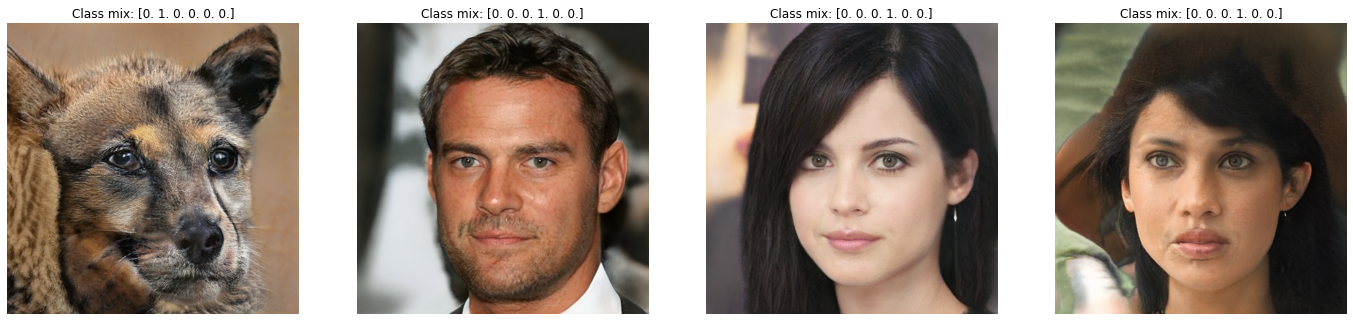

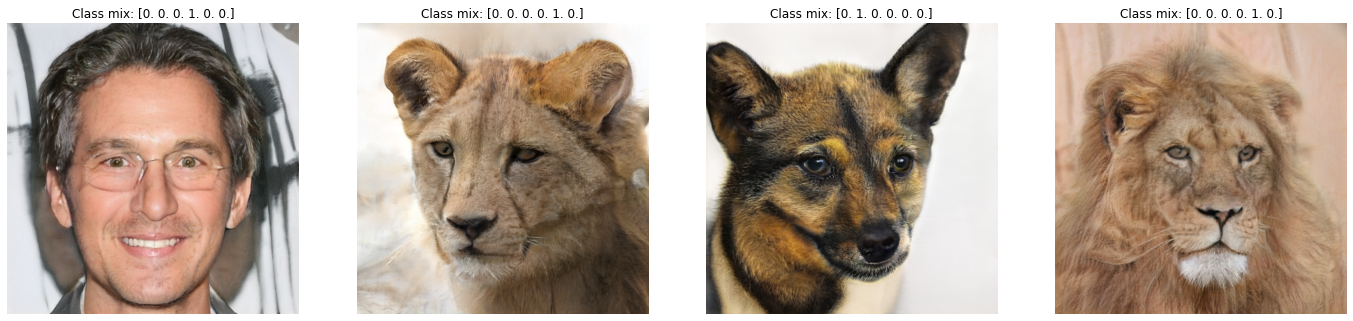

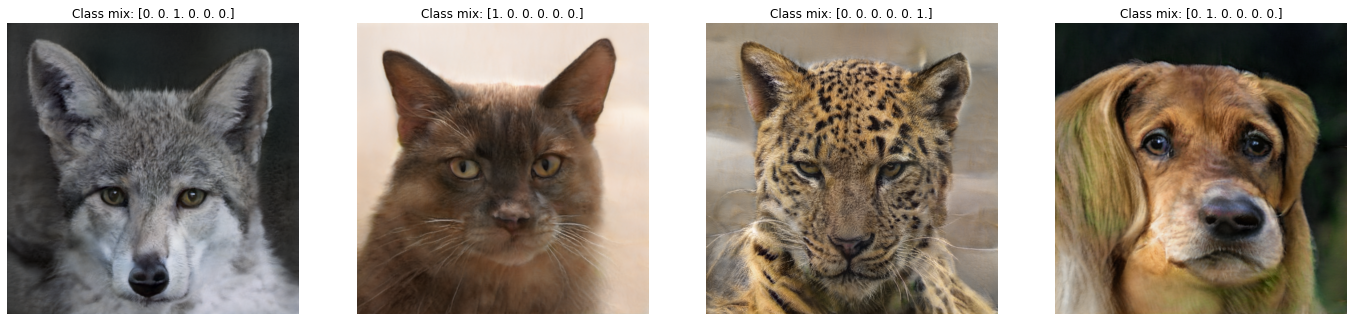

In [ ]:
plot_imgs(generator, 3, 4, truncation = 0.75)

## Generate samples from specific classes:

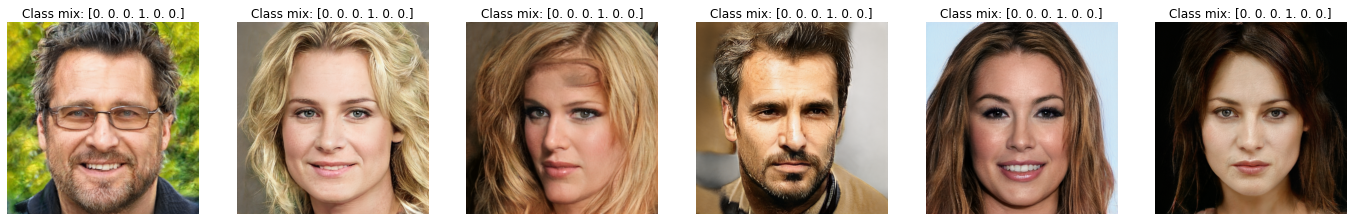

In [ ]:
plot_imgs(generator, 1, 6, class_mix = ['human'], truncation = .8)

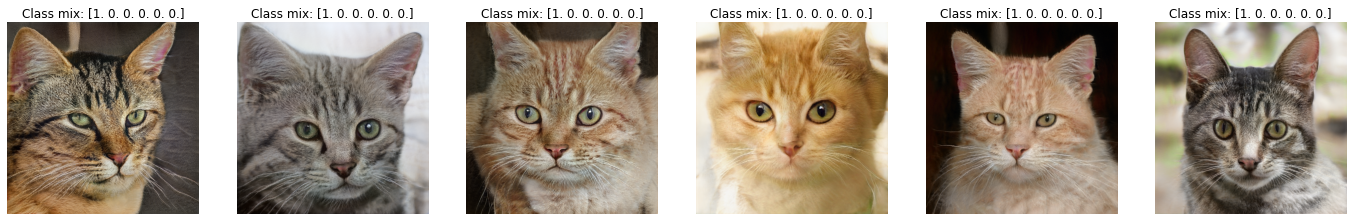

In [ ]:
plot_imgs(generator, 1, 6, class_mix = ['cat'], truncation = 1.)

# Playing with the conditioning mechanism produces class blending!
#### ---> If you find any great new species in here, let me know: @xsteenbrugge

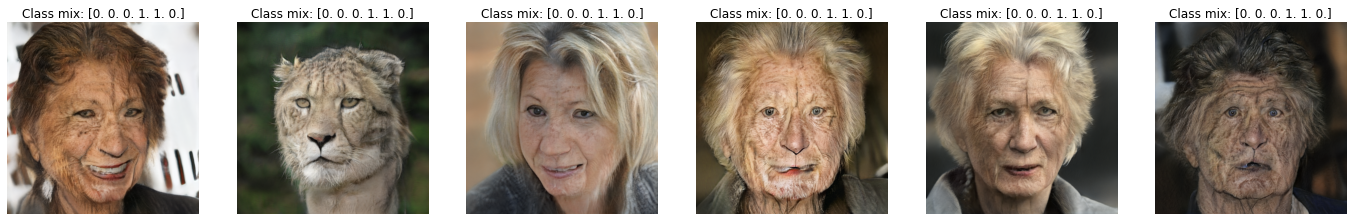

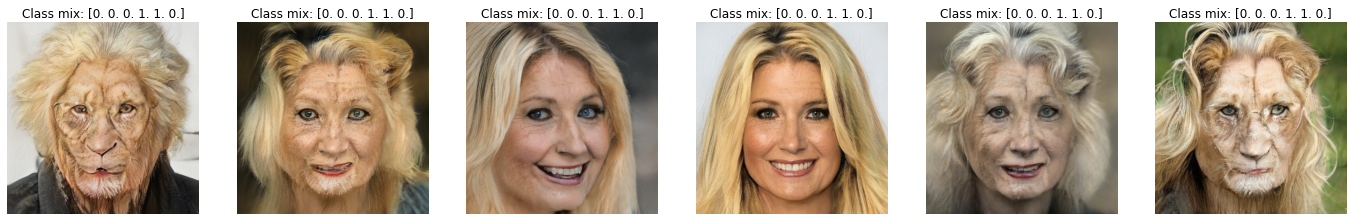

In [ ]:
plot_imgs(generator, 2, 6, class_mix = ['human', 'lion'], truncation = 0.8)

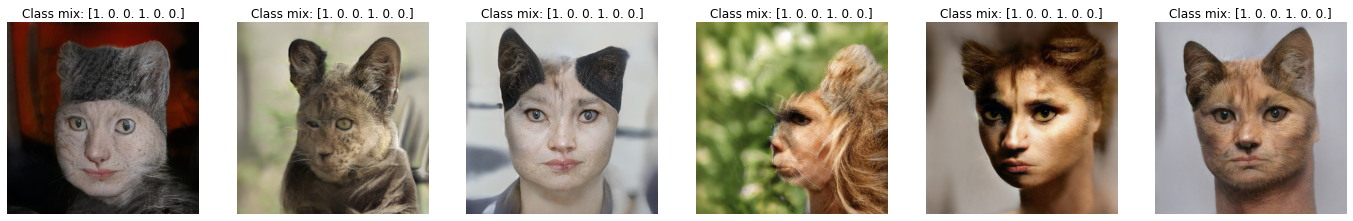

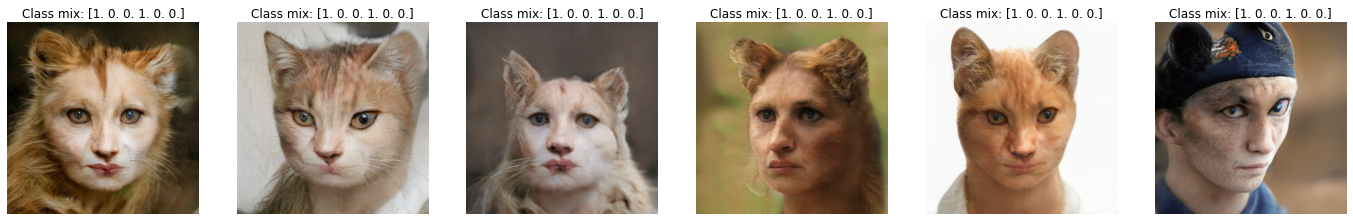

In [ ]:
plot_imgs(generator, 2, 6, class_mix = ['human', 'cat'], truncation = 0.7)

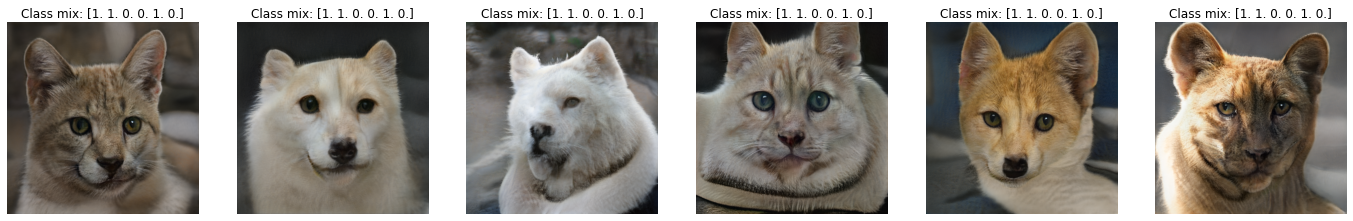

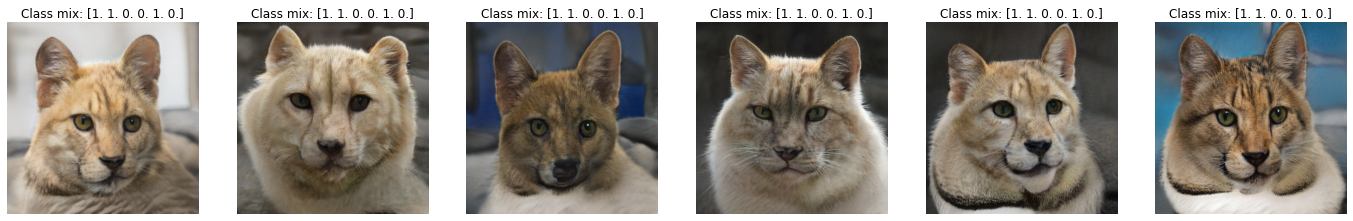

In [ ]:
plot_imgs(generator, 2, 6, class_mix = ['cat', 'dog', 'lion'], truncation = 0.8)

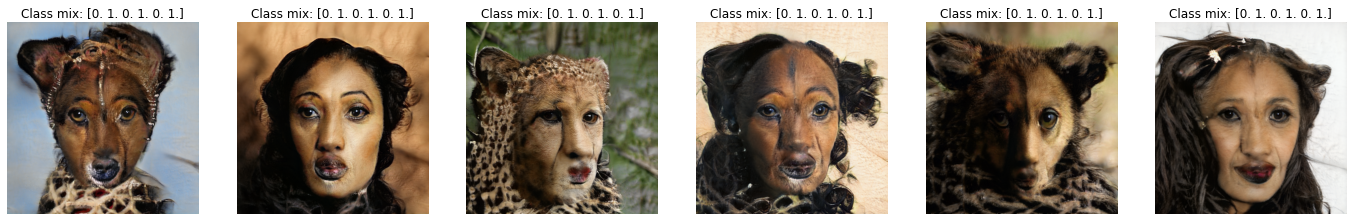

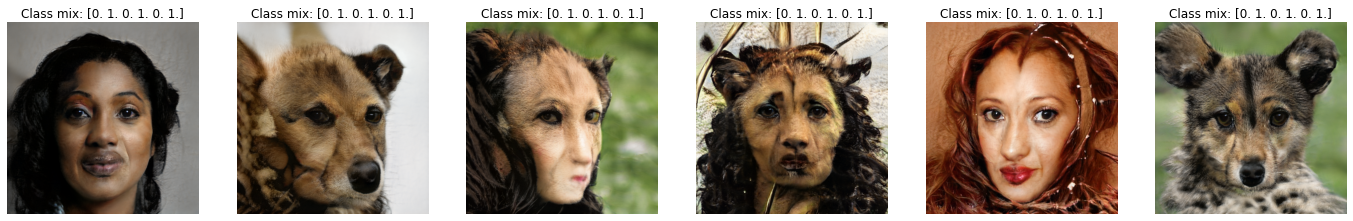

In [ ]:
plot_imgs(generator, 2, 6, class_mix = ['human', 'dog', 'wildcat'], truncation = 0.8)

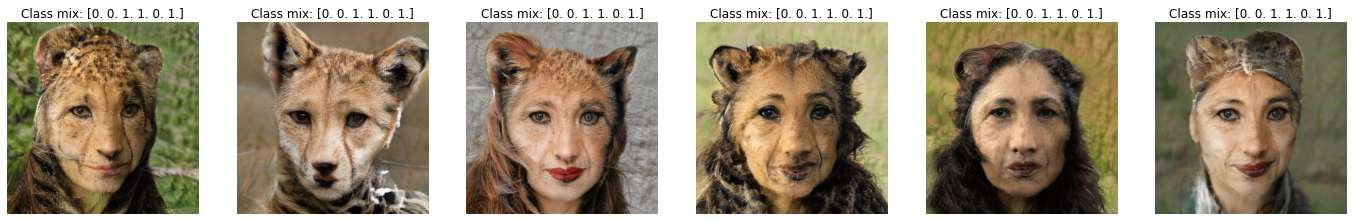

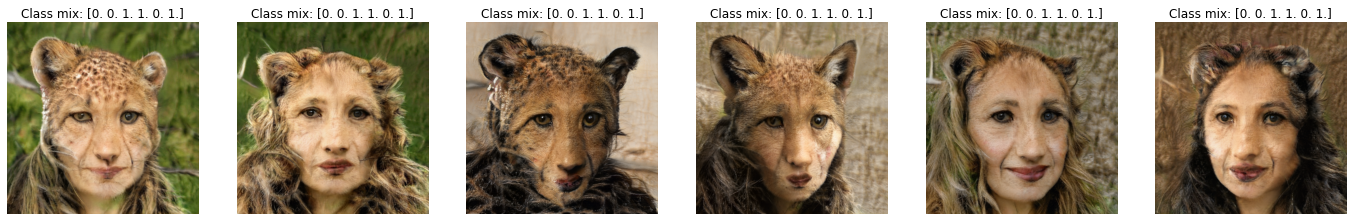

In [ ]:
plot_imgs(generator, 2, 6, class_mix = ['fox/wolf', 'human', 'wildcat'], truncation = 0.6)

# There's plenty of other ways to manipulate the conditioning vector, have fun!